In [ ]:
# import all the necessary libraries here
import keras
import pandas as pd
import tensorflow as tf
import numpy as np
from geopy.distance import geodesic
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.utils import to_categorical
#from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import math
#import argparse
import cv2
import os

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
def getData(labelpath, picpath):
	labels = pd.read_csv(labelpath, sep=",", header=None)
	labels.columns = ["lat", "lon", "pic"]
	outputs = labels[["lat", "lon"]]
	pic_files = labels["pic"]

	inputs = []

	for file in pic_files:
		# load the image, and resize it to be a fixed
		# 224x224 pixels while ignoring aspect ratio
		image = cv2.imread(picpath+file)
		#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = cv2.resize(image, (224, 224)).astype(np.float32)
		# update the input lists
		inputs.append(image)


	# convert the inputs and outputs to NumPy arrays
	inputs = np.array(inputs)
	outputs = np.array(outputs)

	return [inputs, outputs]


In [ ]:
# read data for training
[data, labels] = getData("/content/gdrive/My Drive/Lab5-Material/fdh/label.txt","/content/gdrive/My Drive/Lab5-Material/fdh/images/")

In [ ]:
# normalize data
data = data/255

In [ ]:
# normalize labels
meanlatlon = np.mean(labels,axis=0)
stdlatlon = np.std(labels,axis=0)
normalized_labels = (labels-meanlatlon)/stdlatlon
print(normalized_labels)

[[-0.82965646 -0.74671901]
 [ 0.52045554 -0.25086915]
 [-0.21461199 -0.51609652]
 ...
 [ 0.99367244 -0.59622806]
 [ 0.48490043 -0.01898202]
 [-0.45603315 -0.14475521]]


In [ ]:
np.min(normalized_labels)

-8.776543728205361

In [ ]:
np.max(normalized_labels)

5.31666307366551

In [ ]:
# normalize labels using min-max
maxlatlon = np.max(labels,axis=0)
minlatlon = np.min(labels,axis=0)
normalized_labels2 = (labels-minlatlon)/(maxlatlon-minlatlon)
normalized_labels2

array([[0.46828108, 0.58797037],
       [0.58507945, 0.62427814],
       [0.52148866, 0.60485731],
       ...,
       [0.6260175 , 0.59898981],
       [0.58200357, 0.64125768],
       [0.50060328, 0.63204815]])

In [ ]:
np.min(normalized_labels2)

0.0

In [ ]:
np.max(normalized_labels2)

1.0

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, normalized_labels, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from geopy.distance import geodesic

def custom_loss_function(y_true, y_pred):
   difference = tf.abs(y_true - y_pred)
   #return geodesic(y_true, y_pred).m
   return tf.reduce_sum(difference, axis=-1)

In [ ]:
# construct modified resnet
baseModel = keras.applications.ResNet101(weights="imagenet", include_top=False,	input_tensor=Input(shape=(224, 224, 3)))

# get the output before the classifier
base_output = baseModel.output

# change classifier to regressor output dimension is 2
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(2, kernel_initializer='normal')(base_output)

model = Model(inputs=baseModel.input, outputs=base_output)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

model.compile(loss='mse', optimizer="adam")

171450368/171446536 [==============================] - 1s 0us/step


In [ ]:
print("[INFO] training head...")
history = model.fit(trainX, trainY, epochs=2000, batch_size=128, shuffle=True, validation_data=(testX, testY))

[INFO] training head...
Epoch 1/2000
15/15 [==============================] - 12s 811ms/step - loss: 0.9171 - val_loss: 0.8629
Epoch 2/2000
15/15 [==============================] - 13s 854ms/step - loss: 0.9160 - val_loss: 0.8648
Epoch 3/2000
15/15 [==============================] - 13s 875ms/step - loss: 0.9212 - val_loss: 0.8643
Epoch 4/2000
15/15 [==============================] - 13s 835ms/step - loss: 0.9169 - val_loss: 0.8726
Epoch 5/2000
15/15 [==============================] - 12s 811ms/step - loss: 0.9197 - val_loss: 0.8688
Epoch 6/2000
15/15 [==============================] - 12s 806ms/step - loss: 0.9149 - val_loss: 0.8675
Epoch 7/2000
15/15 [==============================] - 12s 816ms/step - loss: 0.9216 - val_loss: 0.8644
Epoch 8/2000
15/15 [==============================] - 12s 832ms/step - loss: 0.9218 - val_loss: 0.8656
Epoch 9/2000
15/15 [==============================] - 13s 839ms/step - loss: 0.9172 - val_loss: 0.8795
Epoch 10/2000
15/15 [============================

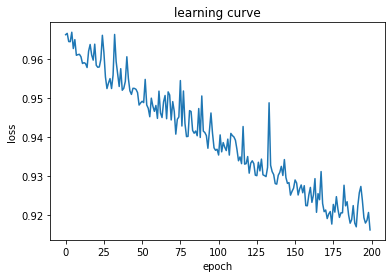

In [ ]:
# this block plots the learning curve 
plt.plot(history.history["loss"])
plt.title('learning curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

(224, 224, 3)


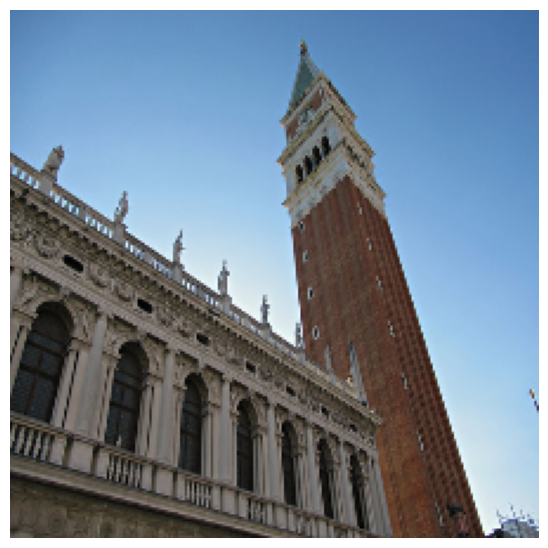

In [ ]:
#image = cv2.imread("/content/gdrive/My Drive/Lab5-Material/fdh/test4.jpg")
image = cv2.imread("/content/gdrive/My Drive/Lab5-Material/fdh/images/125.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
test = cv2.resize(image, (224, 224))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), dpi=100, sharex=True, sharey=True)
ax.imshow(test)
ax.axis('off')

print(test.shape)

In [ ]:
predictY = model.predict((test/255).reshape(1,224,224,3))

In [ ]:
predictY = predictY*(maxlatlon-minlatlon)+minlatlon
print(predictY)

NameError: ignored

In [ ]:
predictY = predictY*stdlatlon+meanlatlon
print(predictY)

[[45.43603756 12.33711475]]


In [ ]:
labels[125]

array([45.434087, 12.339406])

In [ ]:
from geopy.distance import geodesic
geodesic(labels[100], predictY).m

301.1568073503638